# Blockchain Analyse: Untersuchung von Transaktionsgrößen, Gebühren und deren Zusammenhang

Blockchain ist wie ein öffentliches, digitales Kassenbuch, das nicht zentral gesteuert wird.
Es läuft auf vielen Computern gleichzeitig und speichert alle Transaktionen sicher und transparent.
In dieser Analyse schauen wir, ob größere Transaktionen auch mehr Gebühren kosten – also ob es da eine erkennbare Verbindung gibt.

In [8]:
# Dieser Code lädt Informationen über die letzten n Blöcke aus der Bitcoin-Blockchain,
# indem er ein öffentliches API von Blockstream verwendet.

import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr 

def get_blocks_n(n):
    blocks = []
    last_block_hash = None

    while len(blocks) < n:
        if last_block_hash:
            url = f"https://blockstream.info/api/blocks/{last_block_hash}"
        else:
            url = "https://blockstream.info/api/blocks"
        
        response = requests.get(url)
        batch = response.json()

        if not batch: # falls wir keine Blöcke mehr bekommen
            break 

        blocks.extend(batch)

        # speichere die ID des letzten Blocks, um beim nächsten Mal ältere Blöcke abzufragen
        last_block_hash = batch[-1]['id']

    return blocks[:n]  


how_many = 20
blocks = get_blocks_n(how_many)

In [9]:
"""Wenn wir Blöcke mit get_blocks_n(...) abrufen, erhalten wir nur allgemeine Informationen über den Block –
wie z. B. Höhe, Größe, ID usw.
Das reicht jedoch nicht aus, wenn wir eine detaillierte Analyse durchführen möchten.
Deshalb rufen wir zusätzlich Transaktionen des Blocks separat ab.

Über diese Anfrage erhalten wir unter anderem folgende Informationen pro Transaktion:
- txid (Hash)
- version
- locktime
- size
- weight
- fee
- vin (Eingänge)
- vout (Ausgänge)
- status (Blockinfo, Bestätigung usw.)

Trotzdem liefert die API nur die ersten 25 Transaktionen eines Blocks (wegen einer Beschränkung)"""

def get_transactions(block_hash):
    url = f"https://blockstream.info/api/block/{block_hash}/txs"
    response = requests.get(url)
    transactions = response.json()
    return transactions


Durchschnittliche Fee Rate: 59.35 sat/vbyte
Durchschnittliche Transaktionsgröße: 225.67 vbytes
Korrelationskoeffizient (Fee Rate vs. vsize): -0.057
P-Wert: 0.1997682437569892

Dichteste Region der Punkte:
  Fee Rate Bereich: 40.00 – 50.00 sat/vbyte
  Virtuelle Größe Bereich: 100.00 – 150.00 vbytes


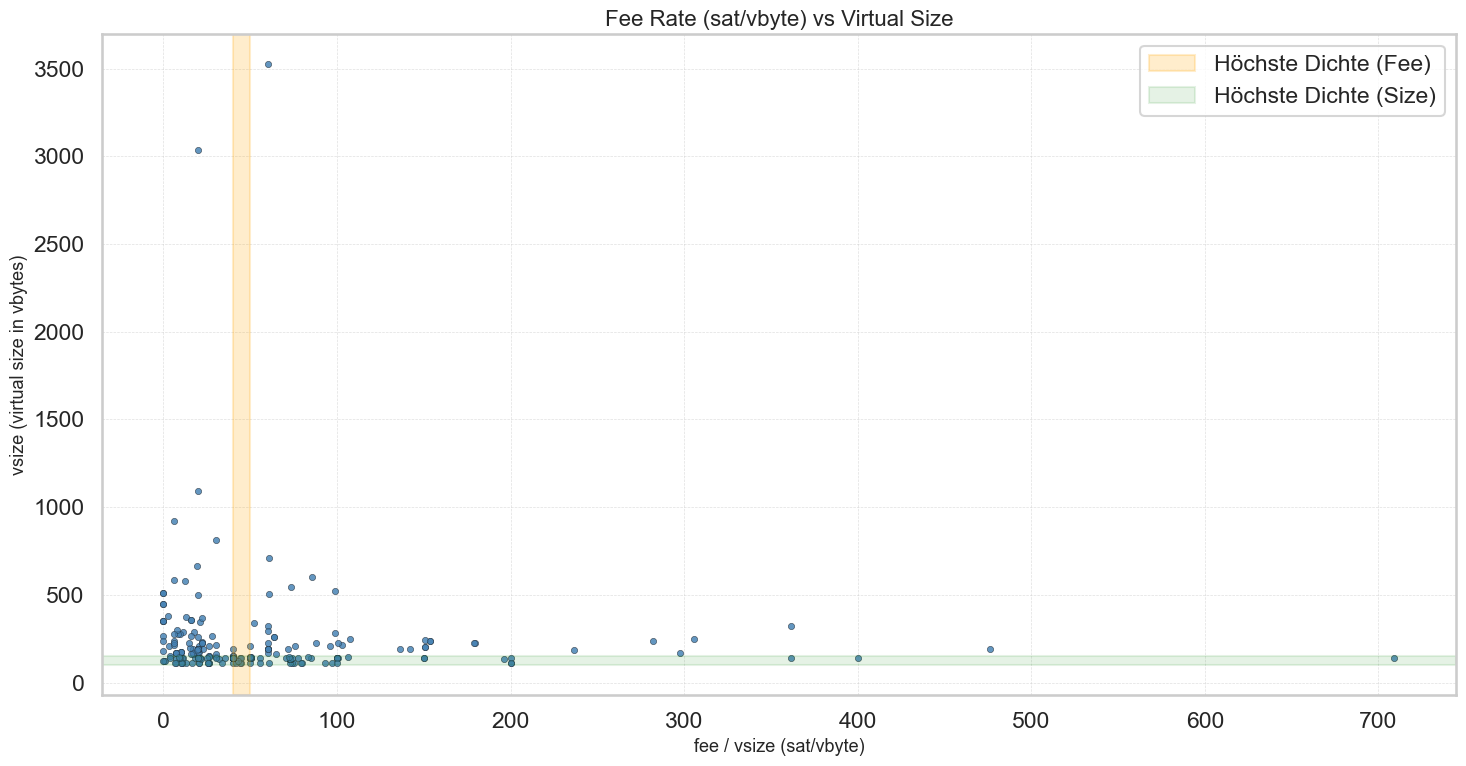

In [10]:
"""Für jede Transaktion berechnen wir zwei Dinge:
- Die virtuelle Größe (vsize), also wie viel "Platz" die Transaktion im Block einnimmt.
- Die Gebühr pro virtuellem Byte (Fee Rate), also wie viele Satoshis pro vByte gezahlt wurden.

Satoshi ist die kleinste Einheit von Bitcoin – 1 Satoshi = 0.00000001 BTC.

Danach berechnen wir den Durchschnitt und schauen, ob es einen Zusammenhang (Korrelation) zwischen der Größe der Transaktion und der Gebühr gibt.
Eine Korrelation zeigt, ob größere Transaktionen typischerweise höhere oder niedrigere Gebühren haben.

Zum Schluss suchen wir den Bereich, in dem sich die meisten Transaktionen befinden, und zeichnen ein Diagramm,
das zeigt, wie Größe und Gebühr zusammenhängen und wo sich die größte Dichte befindet."""

def analyze_blocks(how_many):
    blocks = get_blocks_n(how_many)
    x_vals = []
    y_vals = []

    for block in blocks:
        txs = get_transactions(block['id'])
        total_output = 0
        for tx in txs:
            fee = tx.get('fee')
            weight = tx['weight']
            vsize = (weight + 3) // 4

            for out in tx['vout']:
                total_output += out['value']

            if fee is not None:
                sats_per_vbyte = fee / vsize
                x_vals.append(sats_per_vbyte)
                y_vals.append(vsize)

    avg_fee_rate = np.mean(x_vals)
    avg_vsize = np.mean(y_vals)

    
    corr_coef, p_value = pearsonr(x_vals, y_vals)

    print(f"\nDurchschnittliche Fee Rate: {avg_fee_rate:.2f} sat/vbyte")
    print(f"Durchschnittliche Transaktionsgröße: {avg_vsize:.2f} vbytes")
    print(f"Korrelationskoeffizient (Fee Rate vs. vsize): {corr_coef:.3f}")
    print(f"P-Wert: {p_value}")

    x_bins = np.arange(0, max(x_vals) + 10, 10)
    y_bins = np.arange(0, max(y_vals) + 50, 50)

    heatmap, xedges, yedges = np.histogram2d(x_vals, y_vals, bins=(x_bins, y_bins))
    max_density_idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)

    densest_x_range = (xedges[max_density_idx[0]], xedges[max_density_idx[0] + 1])
    densest_y_range = (yedges[max_density_idx[1]], yedges[max_density_idx[1] + 1])

    print(f"\nDichteste Region der Punkte:")
    print(f"  Fee Rate Bereich: {densest_x_range[0]:.2f} – {densest_x_range[1]:.2f} sat/vbyte")
    print(f"  Virtuelle Größe Bereich: {densest_y_range[0]:.2f} – {densest_y_range[1]:.2f} vbytes")

    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(15, 8))

    plt.scatter(x_vals, y_vals, alpha=0.6, s=20, color="steelblue", edgecolors='k', linewidth=0.3)

    plt.title("Fee Rate (sat/vbyte) vs Virtual Size", fontsize=16)
    plt.xlabel("fee / vsize (sat/vbyte)", fontsize=13)
    plt.ylabel("vsize (virtual size in vbytes)", fontsize=13)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

    plt.axvspan(densest_x_range[0], densest_x_range[1], color='orange', alpha=0.2, label='Höchste Dichte (Fee)')
    plt.axhspan(densest_y_range[0], densest_y_range[1], color='green', alpha=0.1, label='Höchste Dichte (Size)')
    plt.legend()

    plt.tight_layout()
    plt.show()

analyze_blocks(how_many)